<a href="https://colab.research.google.com/github/JunyiJ/DeepGenerativeModels/blob/master/PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


# b. MNIST Data Loader

In [2]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **1. PixelCNN**


# a. Training Function

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, input_dim, output_dim, kernel_size, stride=1, padding=0, bias=True):
      super().__init__(input_dim, output_dim, kernel_size, stride, padding, bias=bias)
      assert (mask_type in ('A', 'B')), "mask_type should be either type A or B"
      self.mask_type = mask_type
      self.register_buffer('mask', torch.ones(self.weight.data.size()))
      _, _, H, W = self.weight.size()
      self.mask[:, :, H//2, W//2 + 1:] = 0
      self.mask[:, :, H//2+1:, :] = 0
      if self.mask_type == 'A':
        self.mask[:, :, H//2, W//2] = 0

    def forward(self, x):
      masked_weight = self.weight * self.mask
      return F.conv2d(x, masked_weight, self.bias, self.stride, self.padding)


In [5]:
class ResidualMaskedConv(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1),
        nn.ReLU(),
        MaskedConv2d('B', hidden_dim, hidden_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)
    )

  def forward(self, x):
    return x + self.layers(x)


# c. Model

In [6]:
class PixelCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.layer_list = []
      self.layer_list.append(
        MaskedConv2d('A', input_dim, hidden_dim, kernel_size=3, padding=1)
      )
      for i in range(15):
        self.layer_list.append(ResidualMaskedConv(hidden_dim))
      self.layer_list.append(nn.ReLU())
      self.layer_list.append(nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=1, stride=1))
      self.layer_list.append(nn.ReLU())
      self.layer_list.append(nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=1, stride=1))
      self.layer_list.append(nn.Sigmoid())
      self.layers = nn.Sequential(*self.layer_list)

    def forward(self, x):
        return self.layers(x)

# d. Training

In [7]:

epochs = 20
model = PixelCNN(1, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.1035



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0925



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0889



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0869



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0856



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0846



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0838



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0831



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0826



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0821



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0817



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0814



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0810



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0807



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0804



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0802



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0800



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0797



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0796



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0793



# e. Evaluation (Reconstruction)

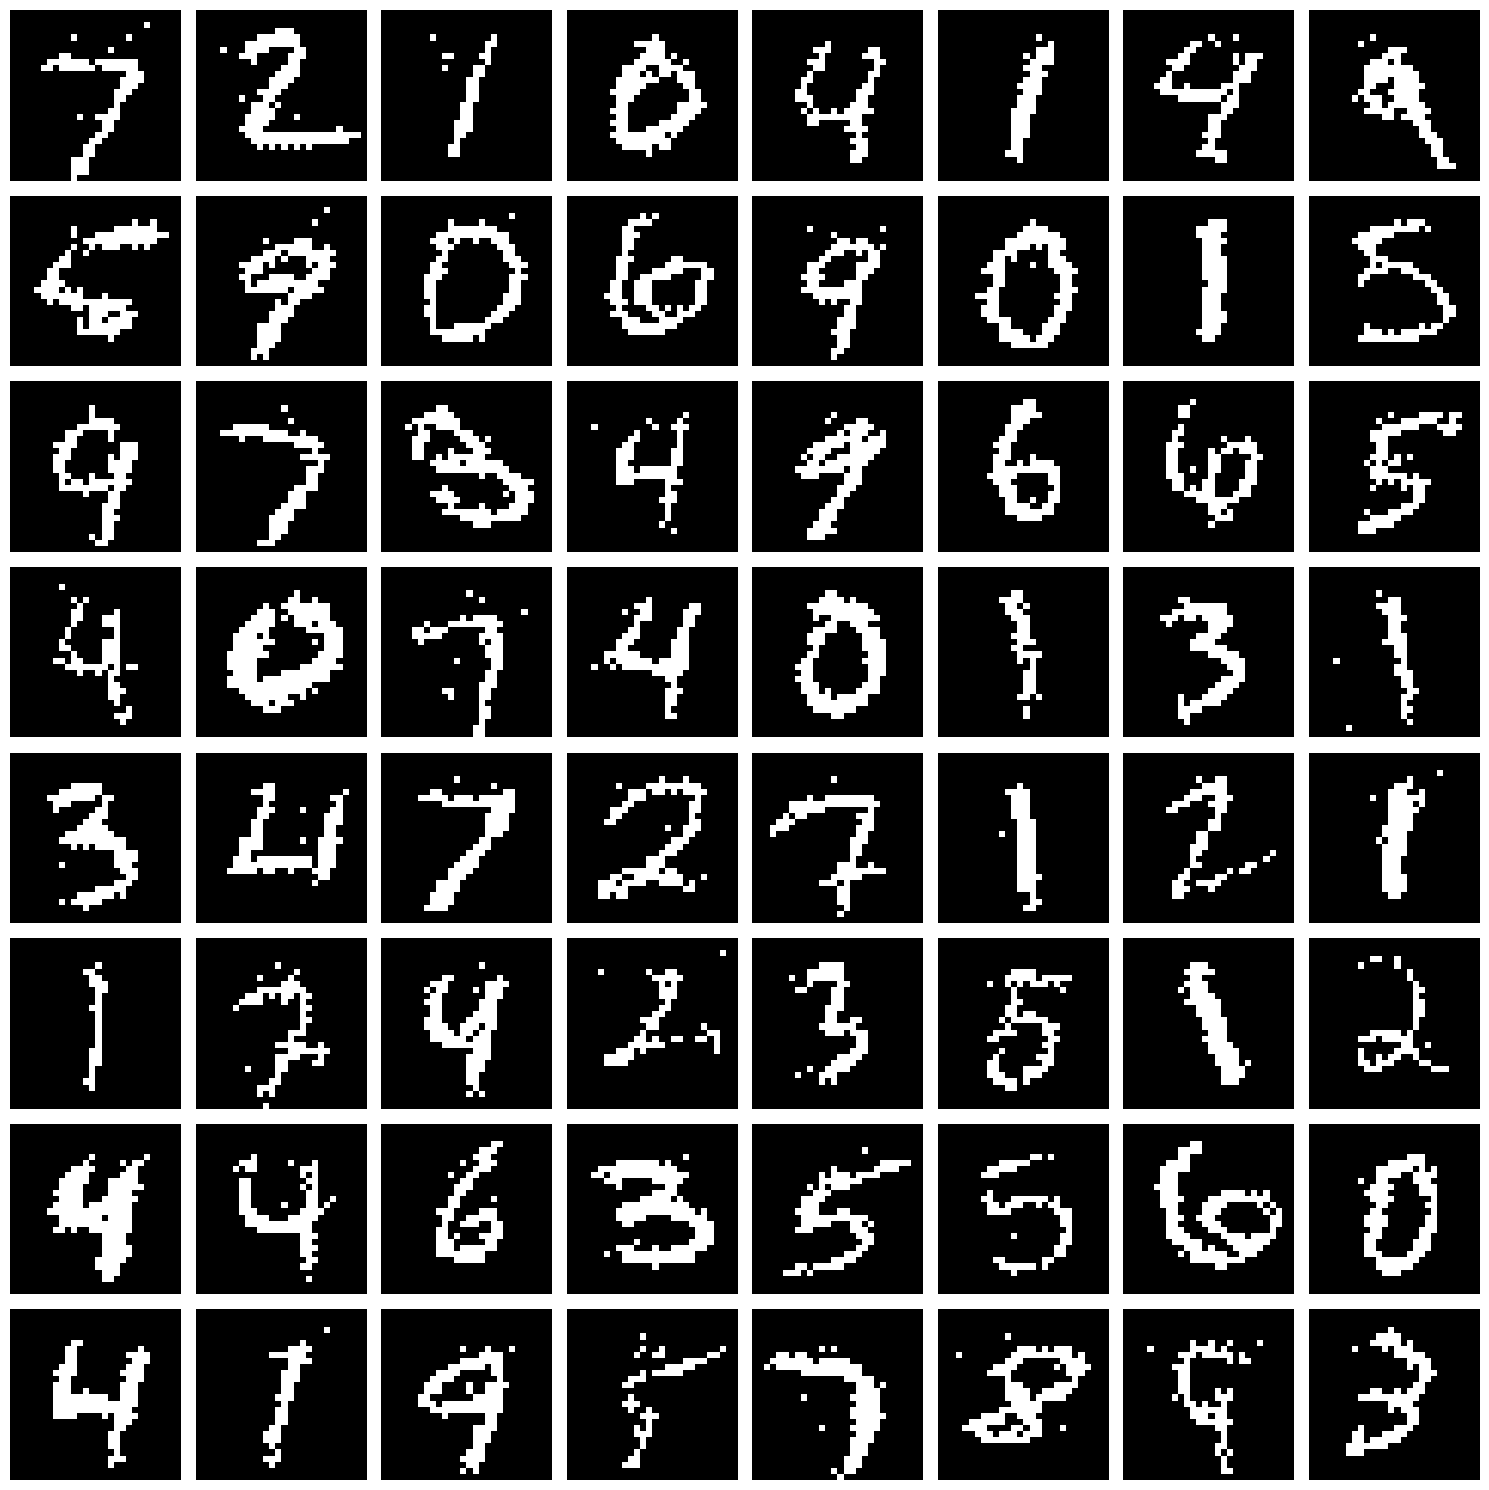

In [8]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

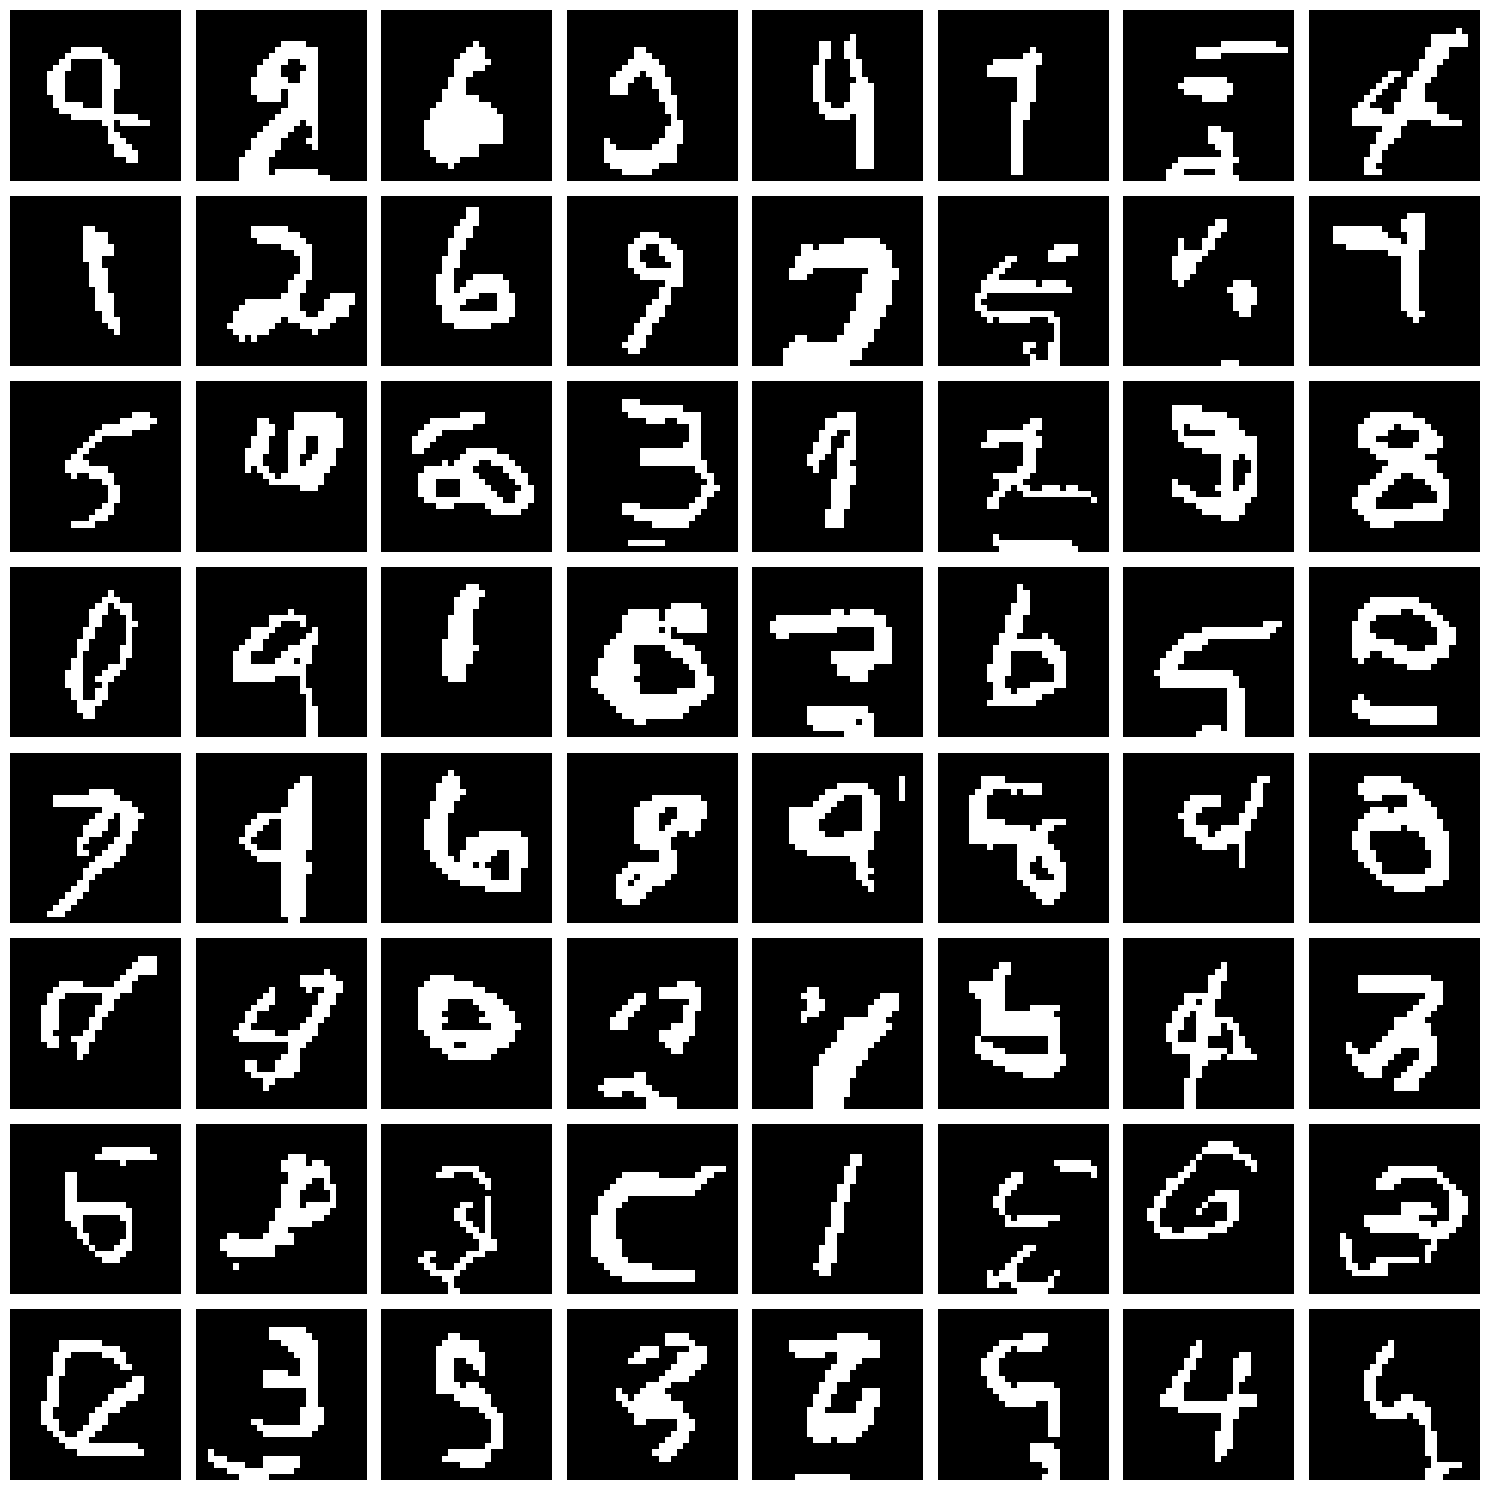

In [9]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [10]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.6f}\n')

    return losses

# b. Conditional Masked Convolution

In [11]:
class ConditionalMaskedConv2d(nn.Module):
    def __init__(self, num_classes, mask_type, input_dim, output_dim, kernel_size, stride=1, padding=0, bias=True):
      super().__init__()
      self.masked_conv = MaskedConv2d(mask_type, input_dim, output_dim, kernel_size, stride, padding, bias=bias)
      self.W = nn.Linear(num_classes, output_dim)
      self.output_dim = output_dim

    def forward(self, x, class_condition):
      biased_weight = self.W(class_condition).unsqueeze(-1).unsqueeze(-1)
      return self.masked_conv(x) + biased_weight

# c. Model

In [12]:
class ResidualConditionalMaskedConv(nn.Module):
  def __init__(self, num_classes, hidden_dim):
    super().__init__()
    self.pre_layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1),
        nn.ReLU()
    )
    self.cmconv = ConditionalMaskedConv2d(num_classes, 'B', hidden_dim, hidden_dim, kernel_size=3, padding=1)
    self.post_layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1)
    )

  def forward(self, x, class_condition):
    y = self.pre_layers(x)
    y = self.cmconv(y, class_condition)
    y = self.post_layers(y)
    return x + y

class ConditionalPixelCNN(nn.Module):
    def __init__(self, num_classes, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.cmconv = ConditionalMaskedConv2d(num_classes, 'A', input_dim, hidden_dim, kernel_size=3, padding=1)
      res_list =[ResidualConditionalMaskedConv(num_classes, hidden_dim) for _ in range(15)]
      self.res_layer = nn.ModuleList(res_list)
      self.post_layer = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=1, stride=1),
        nn.Sigmoid()
      )

    def forward(self, x, class_condition):
        x = self.cmconv(x, class_condition)
        for layer in self.res_layer:
            x = layer(x, class_condition)
        return self.post_layer(x)

# d. Training

In [13]:

epochs = 20
n_classes = 10
model = ConditionalPixelCNN(n_classes, 1, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.112602



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.086850



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.082330



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.080475



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.079325



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.078402



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.077821



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.077136



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.076703



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.076351



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.075865



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.075607



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.075297



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.075026



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.074817



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.074487



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.074295



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.074110



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.073873



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.073677



# e. Evaluation (Reconstruction)

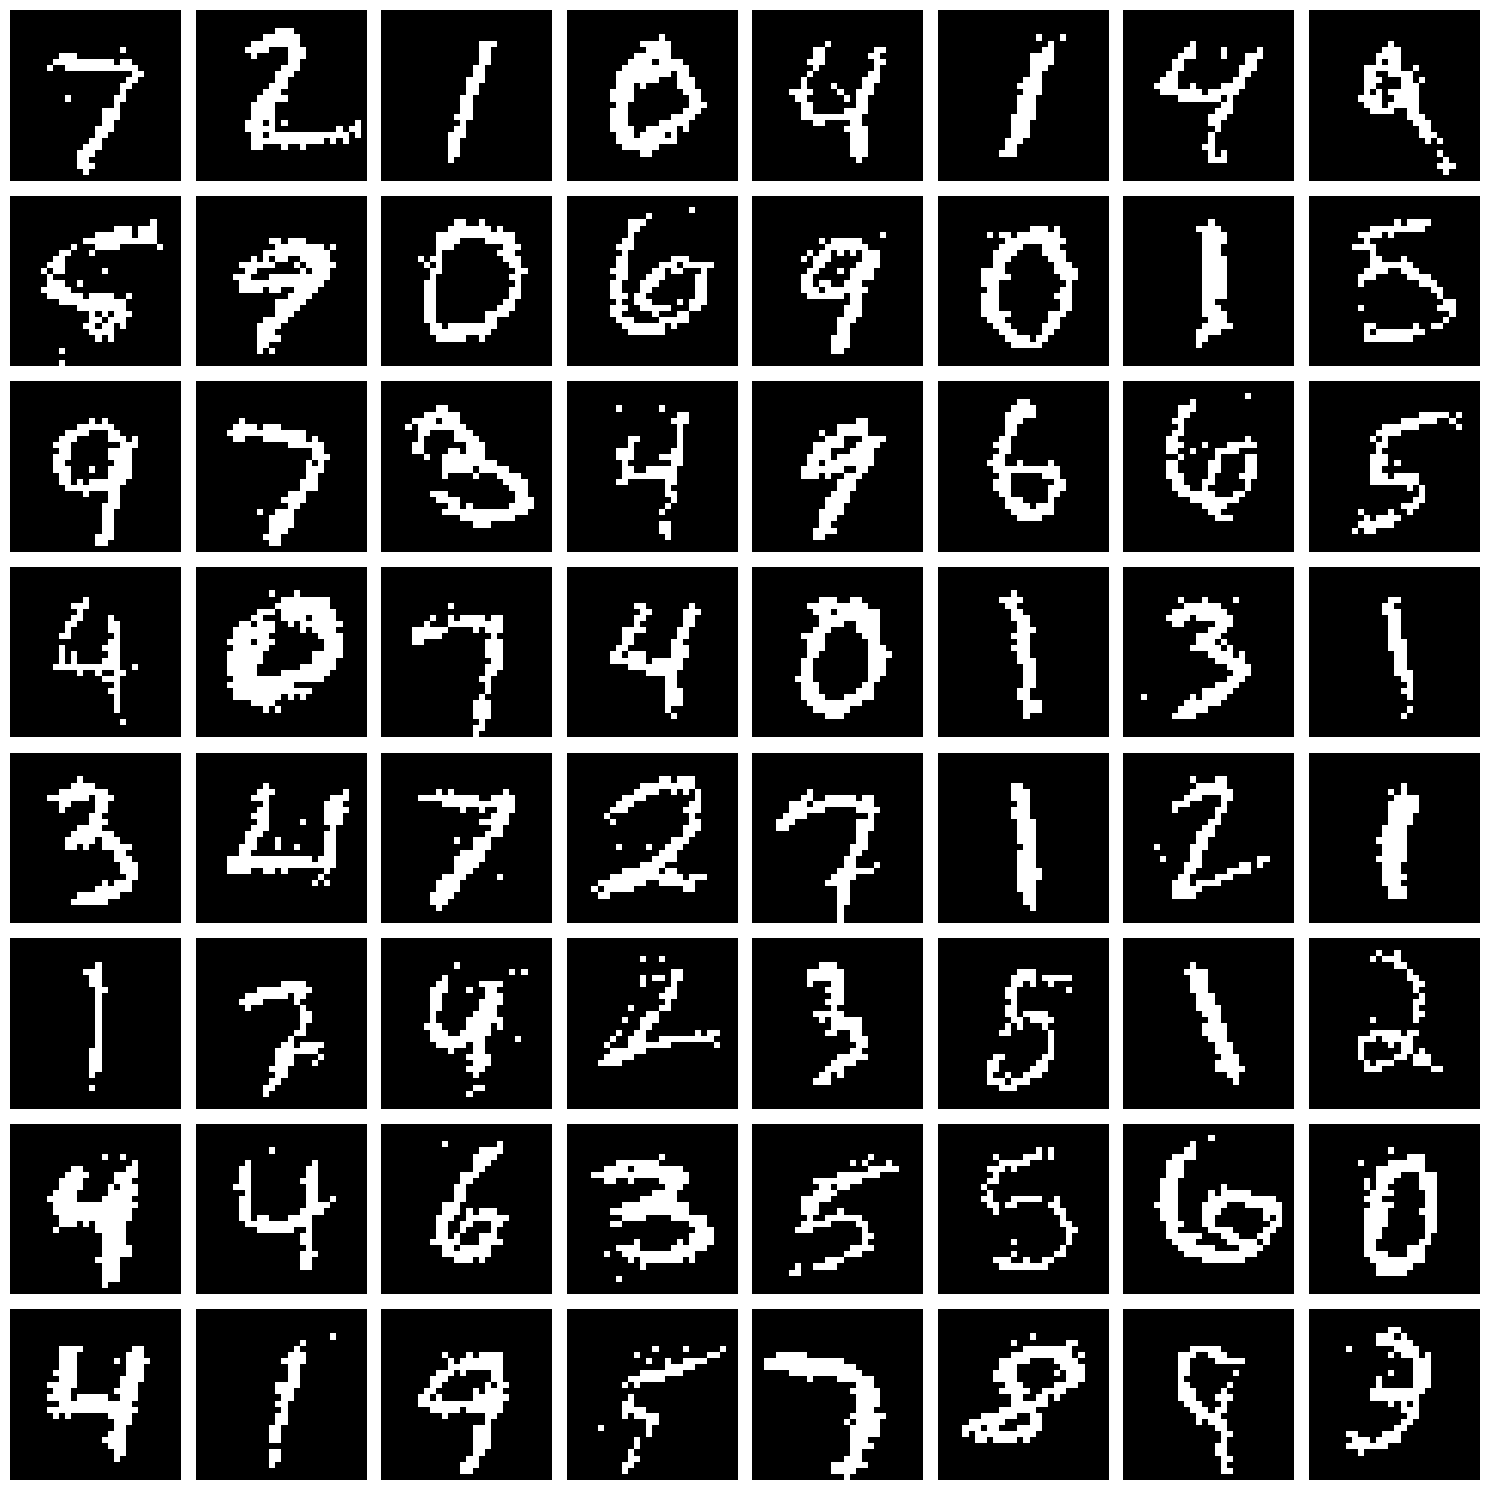

In [14]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

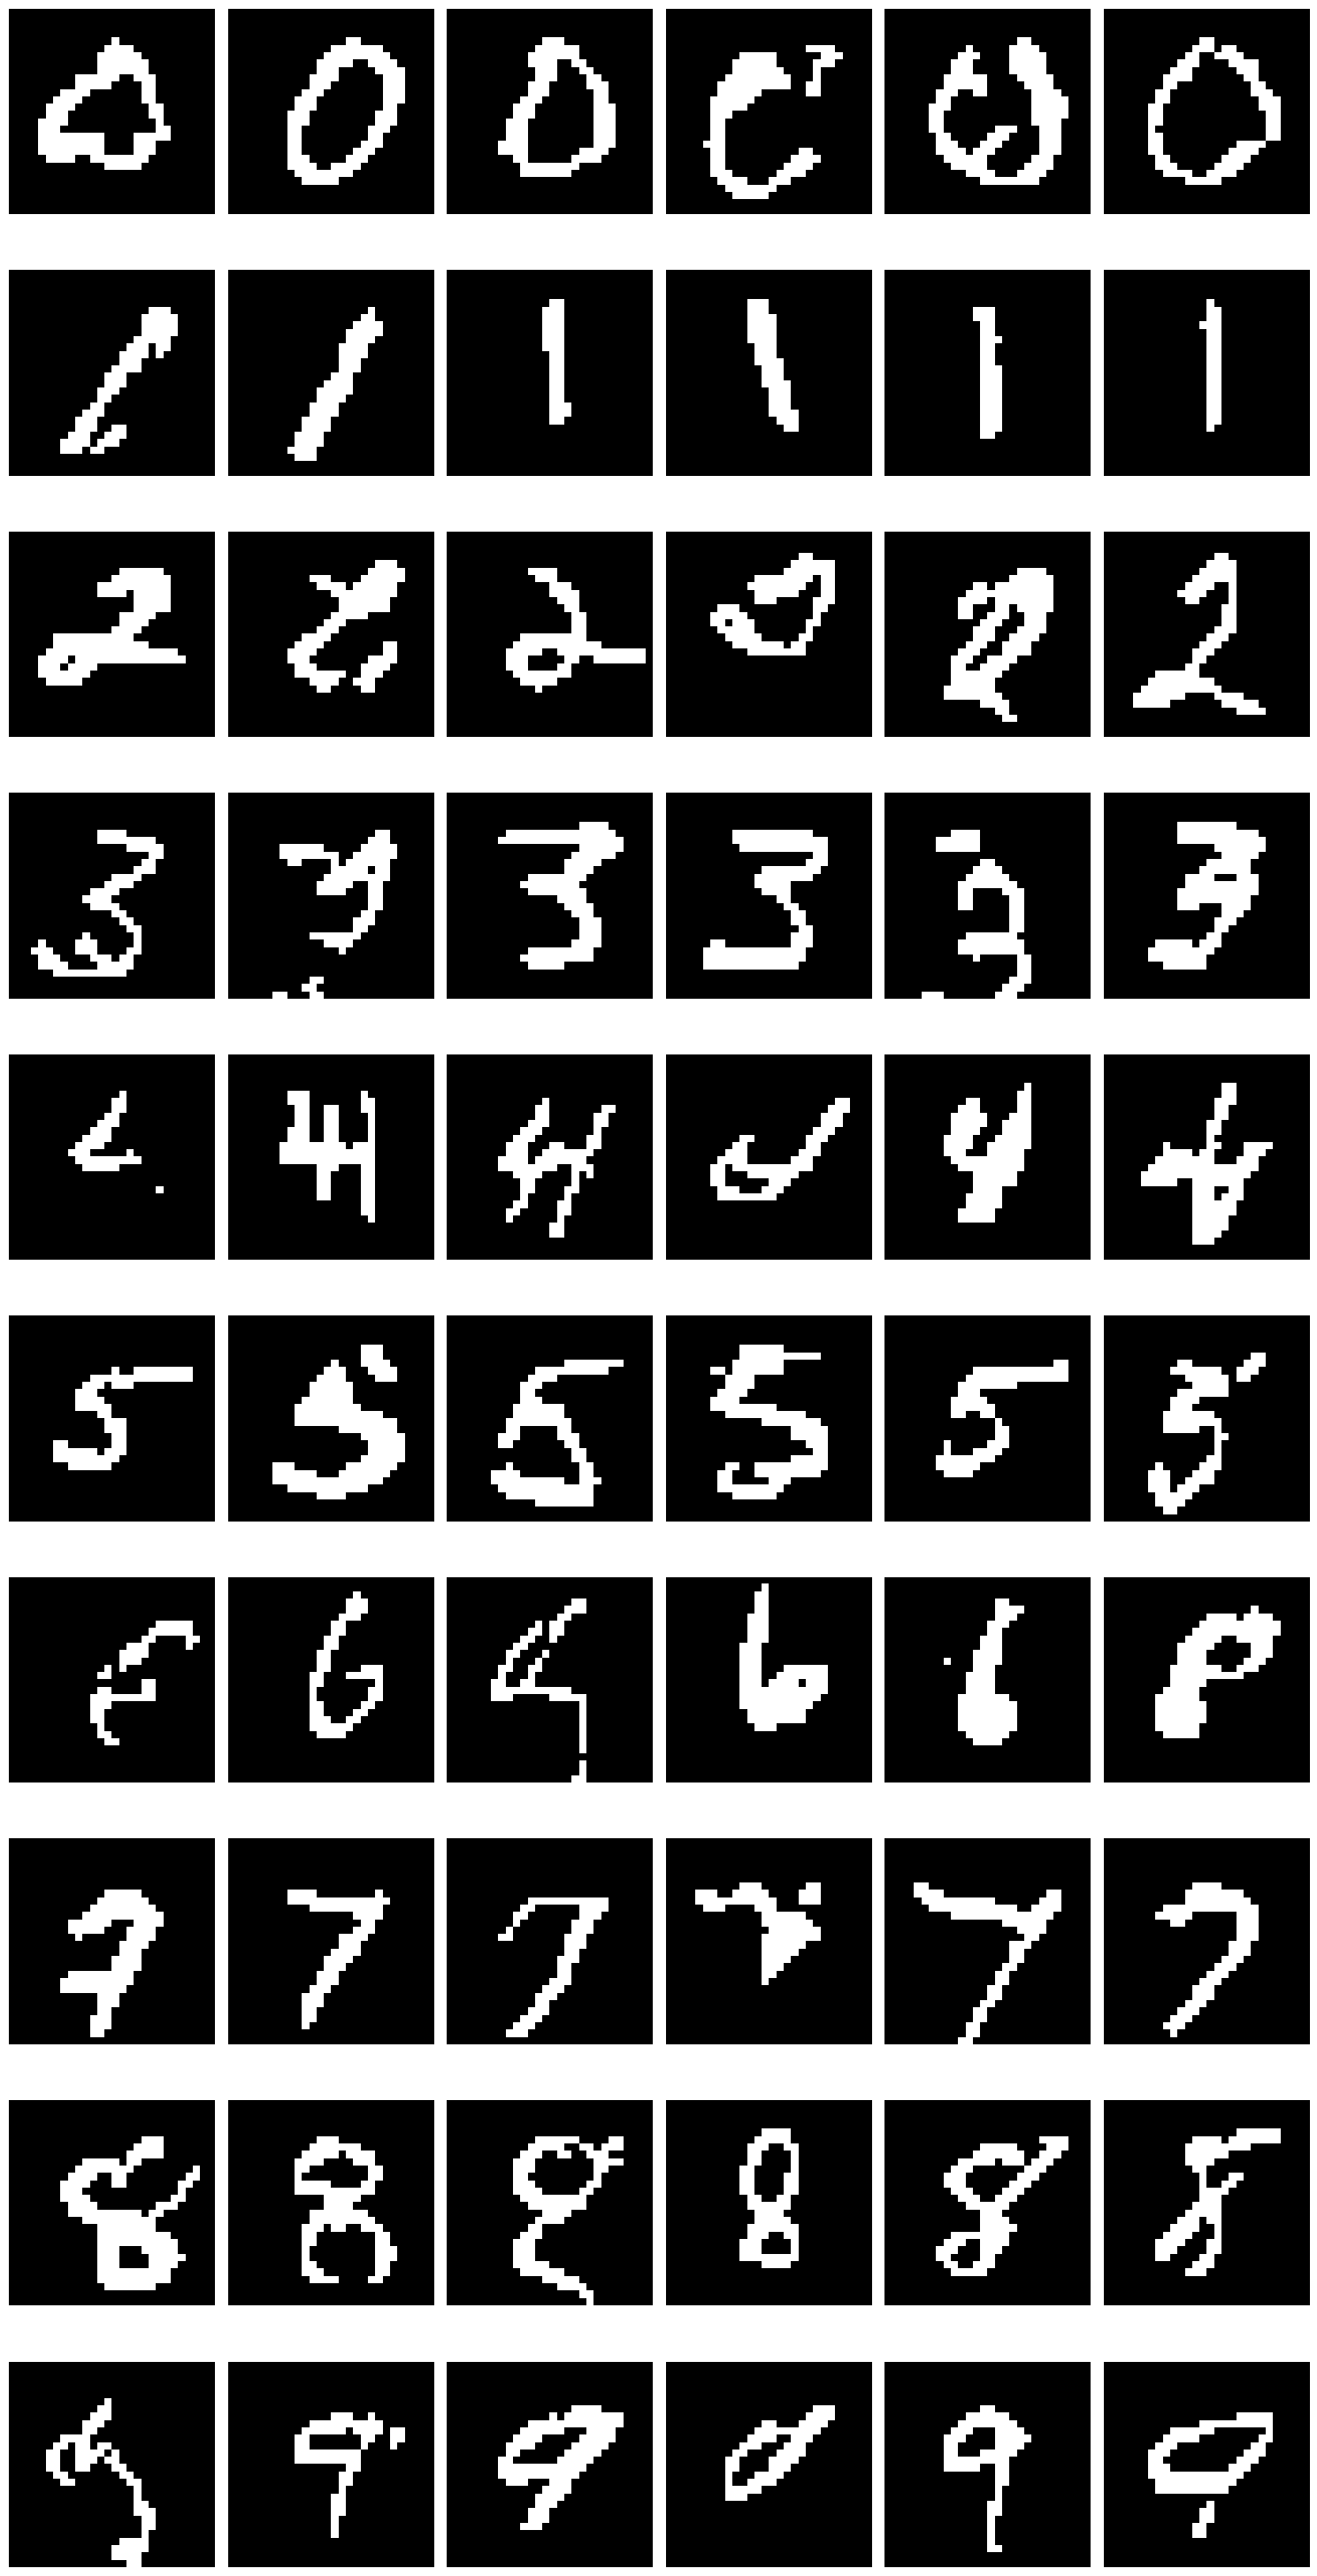

In [15]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            # if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()